# Predicting MLB Slugging Percentage

### April 26, 2025

## Introduction

Professional sports teams in the MLB are constantly looking for ways to predict player performance in order to make insightful decisions about who to sign to their team, who's contracts to extend, who to trade, and who to part ways with. Traditionally, baseball is a sport that is immersed in advanced statistics that can give way to comprehensive analytics. More simple metrics such as batting average, home runs, or walks are a bit easier to predict, but also don't give a complete picture of a batter's effectiveness. More advances stats like on base percentage (OBP), slugging percentage (SLG), and on-base plus slugging (OBPS) are more commonly used to show a players output, but are also much harder to predict.

Slugging percentage is a numerical measurement that is used to represent a player's power with more detail than simply looking at their homeruns. SLG is calculated by giving different weights to different base hits. The equation is:

```
slg = (1*1B + 2*2B + 3*3B + 4*HR) / AB
``` 

where 1B, 2B, 3B, and HR stand for a single, double, triple, and homerun, respectively, and AB is the number of at bats. This statistic weighs different types of hits in a manner that at a glance you can see a batter's power, even if it doesn't always translate directly to home runs.

The following analysis will explore, analyze, and identify with statistics are the most effective at determining a player's slugging percentage. With this information, a team could identify which metrics are easy to predict for different players, and plug those variables in and get an accurate prediction of that players slugging percentage, or how much power they will hit with.

## Exploratory Data Analysis (EDA)

### Introduction to Data

This data was downloaded from MLB's official statistics branch, Baseball Savant (https://baseballsavant.mlb.com/). This tool allows users to select certain seasons, qualifications, and which statistics you want to see. Some of the statistics included in this dataset are

* general hitting statistics like plate appearances and batting average
* bat tracking stastics like average bat speed
* exit velocity and launch angle

The data is from 2015 - 2024, and players with at least 50 plate appearances are included. Many players will have multiple entries since they play multiple seasons, but this should not matter when trying to predict slugging percentage.

For reference, here is a table containing every statistic in the data, and what that statistic measures.

| Variable Name      | Definition                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| ------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| pa                 | A plate appearance refers to a batter's turn at the plate. Each completed turn batting is one plate appearance. Plate appearances can often be confused with at-bats. But unlike with at-bats -- which only occur on certain results -- a plate appearance takes into account every single time a batter comes up and a result between batter and pitcher is obtained.                                                                                                                                                                                      |
| home_run           | A home run occurs when a batter hits a fair ball and scores on the play without being put out or without the benefit of an error.                                                                                                                                                                                                                                                                                                                                                                                                                           |
| walk               | A walk (or base on balls) occurs when a pitcher throws four pitches out of the strike zone, none of which are swung at by the hitter. After refraining from swinging at four pitches out of the zone, the batter is awarded first base. In the scorebook, a walk is denoted by the letters BB.                                                                                                                                                                                                                                                              |
| k_percent          | Strikeout rate represents the frequency with which a pitcher strikes out hitters, as determined by total strikeouts divided by total batters faced.                                                                                                                                                                                                                                                                                                                                                                                                         |
| bb_percent         | Walk rate represents the frequency with which a pitcher walks hitters, as determined by total walks divided by total batters faced. It's an important tool for assessing a pitcher's capabilities and perhaps the most important in judging a pitcher's tendency to walk batters.                                                                                                                                                                                                                                                                           |
| batting_avg        | One of the oldest and most universal tools to measure a hitter's success at the plate, batting average is determined by dividing a player's hits by his total at-bats for a number between zero (shown as .000) and one (1.000). In recent years, the league-wide batting average has typically hovered around .250.                                                                                                                                                                                                                                        |
| slg_percent        | Slugging percentage represents the total number of bases a player records per at-bat. Unlike on-base percentage, slugging percentage deals only with hits and does not include walks and hit-by-pitches in its equation.                                                                                                                                                                                                                                                                                                                                    |
| on_base_percent    | OBP refers to how frequently a batter reaches base per plate appearance. Times on base include hits, walks and hit-by-pitches, but do not include errors, times reached on a fielder's choice or a dropped third strike. (Separately, sacrifice bunts are removed from the equation entirely, because it is rarely a hitter's decision to sacrifice himself, but rather a manager's choice as part of an in-game strategy.)                                                                                                                                 |
| b_rbi              | A batter is credited with an RBI in most cases where the result of his plate appearance is a run being scored. There are a few exceptions, however. A player does not receive an RBI when the run scores as a result of an error or ground into double play.                                                                                                                                                                                                                                                                                                |
| xba                | Expected Batting Average (xBA) is a Statcast metric that measures the likelihood that a batted ball will become a hit.                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| woba               | wOBA is a version of on-base percentage that accounts for how a player reached base -- instead of simply considering whether a player reached base. The value for each method of reaching base is determined by how much that event is worth in relation to projected runs scored (example: a double is worth more than a single).                                                                                                                                                                                                                          |
| xwoba              | Expected Weighted On-base Average (xwOBA) is formulated using exit velocity, launch angle and, on certain types of batted balls, Sprint Speed.                                                                                                                                                                                                                                                                                                                                                                                                              |
| xobp               | xOBP estimates the likelihood of a hit or out based on the quality of contact and the player’s speed                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| avg_swing_speed    | The average speed at which a batter swings the bat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| fast_swing_rate    | Statcast defines a “fast swing” as one that reaches a swing speed of 75 MPH. A player’s “fast-swing rate” is simply showing the percentage of all of his swings that did reach 75 MPH. In the first month of 2024, 23% of all swings qualified as a ‘fast swing.’                                                                                                                                                                                                                                                                                           |
| blasts_contact     | A blast, in Statcast terms, is when a batter squares up a ball and does so with a high bat speed. (To best understand, please review the definition for [a squared-up ball](https://www.mlb.com/glossary/statcast/squared-up), or the efficiency of a batter’s contact, first.)                                                                                                                                                                                                                                                                             |
| blasts_swing       | A blast, in Statcast terms, is when a batter squares up a ball and does so with a high bat speed. (To best understand, please review the definition for [a squared-up ball](https://www.mlb.com/glossary/statcast/squared-up), or the efficiency of a batter’s contact, first.)                                                                                                                                                                                                                                                                             |
| squared_up_contact | A swing’s squared-up rate tells us how much of the highest possible exit velocity available (based on the physics related to the swing speed and pitch speed) a batter was able to obtain – it is, at its simplest, how much exit velocity did you get as a share of how much exit velocity was possible based on your swing speed and the speed of the pitch. A swing that is 60% squared up, for example, tells you that the batter attained 60% of the maximum possible exit velocity available to him, again based on the speed of the swing and pitch. |
| squared_up_swing   | A swing’s squared-up rate tells us how much of the highest possible exit velocity available (based on the physics related to the swing speed and pitch speed) a batter was able to obtain – it is, at its simplest, how much exit velocity did you get as a share of how much exit velocity was possible based on your swing speed and the speed of the pitch. A swing that is 60% squared up, for example, tells you that the batter attained 60% of the maximum possible exit velocity available to him, again based on the speed of the swing and pitch. |
| exit_velocity_avg  | Exit Velocity measures the speed of the baseball as it comes off the bat, immediately after a batter makes contact. This is tracked for all Batted Ball Events -- outs, hits and errors.                                                                                                                                                                                                                                                                                                                                                                    |
| launch_angle_avg   | Launch Angle measures the vertical angle, in degrees, at which the ball leaves a player's bat after being hit.                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| sweet_spot_percent | Colloquially, a player who hits the ball solidly is said to have gotten the "sweet spot" of the bat on the ball. The sweet spot classification quantifies that as a batted-ball event with a launch angle ranging from 8 to 32 degrees.                                                                                                                                                                                                                                                                                                                     |
| barrel_batted_rate | The Barrel classification is assigned to batted-ball events whose comparable hit types (in terms of exit velocity and launch angle) have led to a minimum .500 batting average and 1.500 slugging percentage since Statcast was implemented Major League wide in 2015.                                                                                                                                                                                                                                                                                      |
| hard_hit_percent   | Statcast defines a 'hard-hit ball' as one hit with an exit velocity of 95 mph or higher, and a player's "hard-hit rate" is simply showing the percentage of batted balls that were hit at 95 mph or more.                                                                                                                                                                                                                                                                                                                                                   |
| whiff_percent      | The ratio of swings and misses to the total number of swings                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| swing_percent      | The percenrage os pitches at which a batter swings                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |

Import packages

In [589]:
# Standard operational packages
import numpy as np
import pandas as pd

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# For data modeling
from sklearn.linear_model import LinearRegression

#For metrics and helpful functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For displaying all columns in dataframe
pd.set_option('display.max_columns', None)

Load datasets

In [590]:
df = pd.read_csv('Data/stats.csv')

In [591]:
print(df.shape)

(5336, 29)


There are 5,336 rows in our data, each containing a season from a player.

In [592]:
df.columns

Index(['last_name, first_name', 'player_id', 'year', 'pa', 'home_run', 'walk',
       'k_percent', 'bb_percent', 'batting_avg', 'slg_percent',
       'on_base_percent', 'b_rbi', 'xba', 'woba', 'xwoba', 'xobp',
       'avg_swing_speed', 'fast_swing_rate', 'blasts_contact', 'blasts_swing',
       'squared_up_contact', 'squared_up_swing', 'exit_velocity_avg',
       'launch_angle_avg', 'sweet_spot_percent', 'barrel_batted_rate',
       'hard_hit_percent', 'whiff_percent', 'swing_percent'],
      dtype='object')

In [593]:
print(df.dtypes)

last_name, first_name     object
player_id                  int64
year                       int64
pa                         int64
home_run                   int64
walk                       int64
k_percent                float64
bb_percent               float64
batting_avg              float64
slg_percent              float64
on_base_percent          float64
b_rbi                      int64
xba                      float64
woba                     float64
xwoba                    float64
xobp                     float64
avg_swing_speed          float64
fast_swing_rate          float64
blasts_contact           float64
blasts_swing             float64
squared_up_contact       float64
squared_up_swing         float64
exit_velocity_avg        float64
launch_angle_avg         float64
sweet_spot_percent       float64
barrel_batted_rate       float64
hard_hit_percent         float64
whiff_percent            float64
swing_percent            float64
dtype: object


### Data Cleaning & Preprocessing

Let's first check for null or missing data.

In [594]:
df.isna().sum()

last_name, first_name       0
player_id                   0
year                        0
pa                          0
home_run                    0
walk                        0
k_percent                   0
bb_percent                  0
batting_avg                 0
slg_percent                 0
on_base_percent             0
b_rbi                       0
xba                         0
woba                        0
xwoba                       0
xobp                        0
avg_swing_speed          4306
fast_swing_rate          4306
blasts_contact           4306
blasts_swing             4306
squared_up_contact       4306
squared_up_swing         4306
exit_velocity_avg           0
launch_angle_avg            0
sweet_spot_percent          0
barrel_batted_rate          0
hard_hit_percent            0
whiff_percent               0
swing_percent               0
dtype: int64

There are a number of missing values for a few of the statistics. This is due to which stats are tracked given the year. The entire dataset only back to 2015, however, certain advanced metrics related to bat tracking were not collected this entire time. The bat tracking metrics are only available starting from the second half of the 2023 season. Due to this, I will create multiple dataframes to separate the data containing these metrics from the rest, and compare how well the models work at the end to see how important these are for slugging percentage.

In [595]:
# Store data with bat tracking metrics
df_tracking = df[~df.isna().any(axis=1)]
df.drop(columns=['avg_swing_speed', 'fast_swing_rate', 'blasts_contact', 'blasts_swing', 'squared_up_contact', 'squared_up_swing'], inplace=True)
df_tracking.isna().sum()

last_name, first_name    0
player_id                0
year                     0
pa                       0
home_run                 0
walk                     0
k_percent                0
bb_percent               0
batting_avg              0
slg_percent              0
on_base_percent          0
b_rbi                    0
xba                      0
woba                     0
xwoba                    0
xobp                     0
avg_swing_speed          0
fast_swing_rate          0
blasts_contact           0
blasts_swing             0
squared_up_contact       0
squared_up_swing         0
exit_velocity_avg        0
launch_angle_avg         0
sweet_spot_percent       0
barrel_batted_rate       0
hard_hit_percent         0
whiff_percent            0
swing_percent            0
dtype: int64

The next concern to address is the number of plate appearances (pa), or the amount of at bats a player had that season.

In [596]:
df[['pa', 'batting_avg', 'home_run', 'slg_percent']].describe()

,pa,batting_avg,home_run,slg_percent
count,5336.000000,5336.000000,5336.000000,5336.000000
mean,314.392616,0.236105,9.978823,0.385226
std,200.266348,0.047529,9.737093,0.098708
min,50.000000,0.000000,0.000000,0.000000
25%,132.000000,0.211000,2.000000,0.329000
50%,274.000000,0.242000,7.000000,0.391000
75%,484.250000,0.267000,15.000000,0.448000
max,753.000000,0.400000,62.000000,0.755000


The MLB lists minimum qualifications that must be met for players to qualify for certain leaderboards. This prevents a player for example who only had 1 at bat the entire season and got a hit from leading the entire MLB with a 1.0 batting average. For hitters, this minimum amount is 3.1 PA's a game. There are a number of specifics to this calculation, such as when teams play one more or one fewer games, when players are active or not, as well as a specific rookie standard.

This is something we want ot think about before creating our models. Ensuring players have "enough" at bats in a season can help ensure the findings are statistacally relevant, and resistant to being swayed by outliers. Let's visualize the distribution of plate appearances to see if it might have a significant impact on our models.

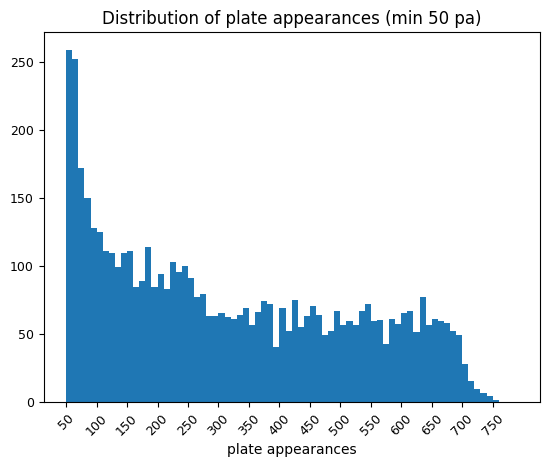

In [597]:
plt.hist(df['pa'], bins=range(50, 800, 10))
plt.xticks(range(50, 800, 50), rotation=45, fontsize=9)
plt.yticks(fontsize=9)
plt.title('Distribution of plate appearances (min 50 pa)')
plt.xlabel('plate appearances')
plt.show()

We can see the distribution is skewed right by a significant margin. Let's separate the data and see how the distribution looks. A boxplot can also be helpful to look for outliers and get an overview of general distribution.

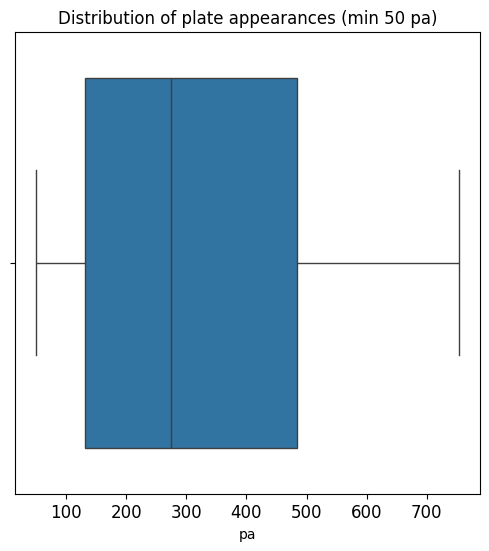

In [598]:
plt.figure(figsize=(6,6))
plt.title('Distribution of plate appearances (min 50 pa)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['pa'])
plt.show()

There are no outliers apparant from the boxplot, but we do see again that the data is skewed right by a large margin. We can make some quick calculations to find out exavtly how much of the data are outliers.

In [599]:
# Calculate percentiles and IQR
p_25 = df['pa'].quantile(0.25)
p_75 = df['pa'].quantile(0.75)
iqr = p_75 - p_25

# Calculate upper and lower limits and find outliers
upper_limit = p_75 + iqr
lower_limit = p_25 - iqr
outliers = df[(df['pa'] > upper_limit) | (df['pa'] < lower_limit)]

# Print  findings
print(f'Upper limit: {upper_limit:.2f}')
print(f'Lower limit: {lower_limit:.2f}')
print(f"Number of outliers in 'pa': {len(outliers)}")

Upper limit: 836.50
Lower limit: -220.25
Number of outliers in 'pa': 0


Mathematically speaking, there are no outliers in our data for plate appearances. The lower limit being a negative number stands out a bit, but it makes sense when you consider how much of the data is at or near the minimum value of 50, and how large the range of the data is. Before we begin any machine learning, I want to create a separate dataframe with only the rows that have a pa value that would qualify for the MLB leaderboards.

To keep things simple, I will apply a blanket qualification by multiplying 3.1 by the number of games each team is expected to play, 162. This will be a cutoff value that I will also use to separate the data to see if this minimum amount has significant impact in our model's performance.

In [600]:
# Setting cutoff value
# Adding one and casting int to "round up" without importing math
pa_cutoff = int(3.1 * 162 + 1)
print(f'Our PA cutoff value: {pa_cutoff}')

Our PA cutoff value: 503


In [601]:
df_min = df[df['pa'] >= pa_cutoff]
df_min[['pa', 'batting_avg', 'home_run', 'slg_percent']].describe()

,pa,batting_avg,home_run,slg_percent
count,1229.000000,1229.000000,1229.000000,1229.000000
mean,605.694060,0.266531,21.852726,0.450853
std,60.320837,0.027142,10.028069,0.063866
min,503.000000,0.168000,0.000000,0.273000
25%,551.000000,0.248000,14.000000,0.407000
50%,605.000000,0.265000,21.000000,0.445000
75%,655.000000,0.284000,29.000000,0.491000
max,753.000000,0.354000,62.000000,0.701000


When comparing this dataset to the one including all players above 50 PA's, we can see the average statistics like batting average and slugging percentage do go up, with a sharp increase in discrete measurements like home runs. Now let's visualize the entire dataframe next to this dataframe with the minimum pa cutoff value applied.

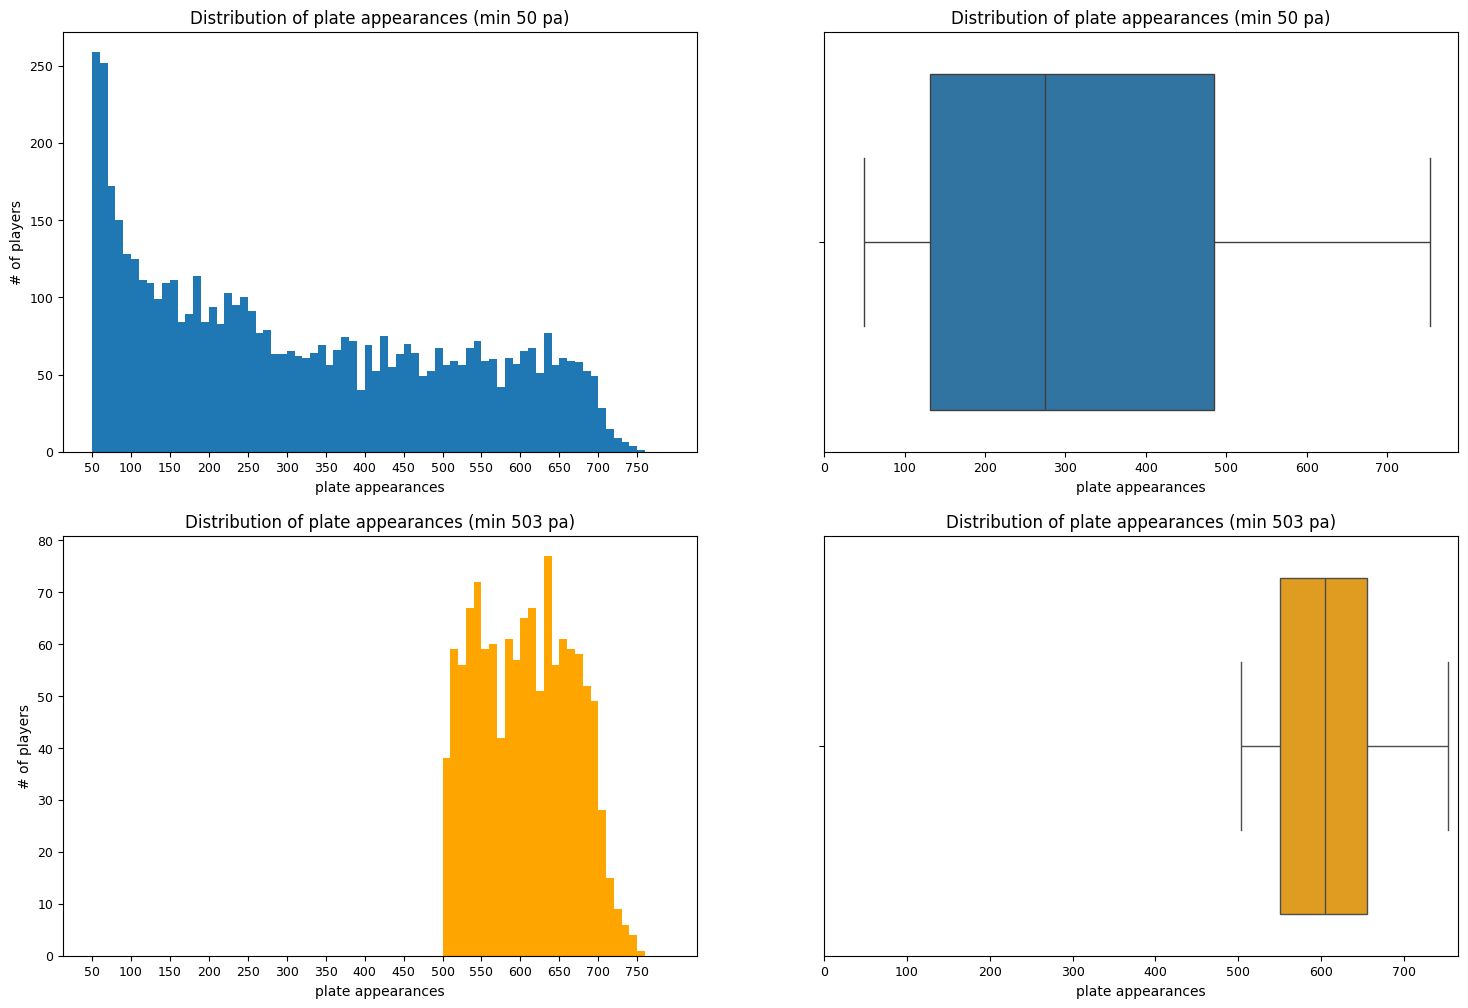

In [602]:
# Set figure and axes
fig, ax = plt.subplots(2, 2, figsize=(18,12))

# Create hist of pa's for all data
ax[0][0].hist(df['pa'], bins=range(50, 800, 10))
ax[0][0].set_xticks(range(50, 800, 50))
ax[0][0].tick_params(axis='both', which='major', labelsize=9)
ax[0][0].set_title('Distribution of plate appearances (min 50 pa)')
ax[0][0].set_xlabel('plate appearances')
ax[0][0].set_ylabel('# of players')

# Create hist of pa's for those above cutoff value
ax[1][0].hist(df_min['pa'], bins=range(50, 800, 10), color='orange')
ax[1][0].set_xticks(range(50, 800, 50))
ax[1][0].tick_params(axis='both', which='major', labelsize=9)
ax[1][0].set_title('Distribution of plate appearances (min 503 pa)')
ax[1][0].set_xlabel('plate appearances')
ax[1][0].set_ylabel('# of players')

# Create boxplot of pa's for all data
sns.boxplot(x=df['pa'], ax=ax[0][1])
ax[0][1].set_title('Distribution of plate appearances (min 50 pa)')
ax[0][1].tick_params(axis='both', which='major', labelsize=9)
ax[0][1].set_xticks(range(0, 800, 100))
ax[0][1].set_xlabel('plate appearances')

# Create boxplot of pa's for those above cutoff value
sns.boxplot(x=df_min['pa'], ax=ax[1][1], color='orange')
ax[1][1].set_title('Distribution of plate appearances (min 503 pa)')
ax[1][1].tick_params(axis='both', which='major', labelsize=9)
ax[1][1].set_xticks(range(0, 800, 100))
ax[1][1].set_xlabel('plate appearances')

# Show plots
plt.show()

The plots are vertically aligned and have the same scale on the x-axis to better compare them. We can see the distributions are much less skewed, especially from the boxplots. The range of values above the 75th percentile is much smaller than for the whole dataset.

We will create another dataset for minimum plate appearances containing only rows with bat tracking metrics as well.

In [603]:
df_tracking_min = df_tracking[df_tracking['pa'] >= pa_cutoff]
print('Stats for seasons with bat tracking metrics:')
print(df_tracking[['pa', 'batting_avg', 'home_run', 'slg_percent']].describe())

print('\nStats for seasons with bat tracking metrics and minimum number of pa:')
print(df_tracking_min[['pa', 'batting_avg', 'home_run', 'slg_percent']].describe())

Stats for seasons with bat tracking metrics:
                pa  batting_avg    home_run  slg_percent
count  1030.000000  1030.000000  1030.00000  1030.000000
mean    346.541748     0.236545    10.82233     0.385516
std     195.993013     0.038318     9.58084     0.083411
min      50.000000     0.077000     0.00000     0.129000
25%     168.000000     0.214000     3.00000     0.332000
50%     336.000000     0.239500     8.00000     0.384000
75%     508.000000     0.262000    16.00000     0.441000
max     753.000000     0.380000    58.00000     0.717000

Stats for seasons with bat tracking metrics and minimum number of pa:
               pa  batting_avg    home_run  slg_percent
count  262.000000   262.000000  262.000000   262.000000
mean   610.793893     0.259958   21.751908     0.440195
std     62.255526     0.025313    9.348279     0.061175
min    503.000000     0.196000    1.000000     0.296000
25%    556.000000     0.244250   15.000000     0.399000
50%    614.000000     0.258500   21

We should also check for any duplicates in our data.

In [604]:
df.duplicated().sum()

np.int64(0)

With our concerns addressed up to this point, and knowing there is no missing or duplicated data, we can now begin to look at some of the more important statistics for our model. There are a number of continuious variables in our dataset, to get a better idea of what these look like, we can look at descriptive stats for all of them.

In [605]:
# get list of all float64 columns
cont_vars = list(df.select_dtypes(['float64']).columns)

# print descriptive statistics
df[cont_vars].describe()

,k_percent,bb_percent,batting_avg,slg_percent,on_base_percent,xba,woba,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,whiff_percent,swing_percent
count,5336.000000,5336.00000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000
mean,23.856466,7.99955,0.236105,0.385226,0.303714,0.233527,0.298851,0.299663,0.303084,88.003017,11.915667,32.462088,6.581372,35.019865,25.797189,47.649082
std,7.952476,3.43164,0.047529,0.098708,0.054743,0.039393,0.057990,0.052905,0.049835,2.657542,5.691268,5.855329,4.396887,9.569253,7.041802,5.376142
min,3.100000,0.00000,0.000000,0.000000,0.000000,0.022000,0.000000,0.040000,0.044000,72.500000,-37.500000,2.500000,0.000000,0.000000,4.700000,23.400000
25%,18.500000,5.70000,0.211000,0.329000,0.279000,0.213000,0.272000,0.274000,0.281000,86.400000,8.700000,29.500000,3.200000,29.400000,21.000000,44.000000
50%,23.100000,7.80000,0.242000,0.391000,0.310000,0.238000,0.305000,0.303000,0.308000,88.200000,12.300000,32.900000,6.100000,35.900000,25.400000,47.500000
75%,28.100000,10.10000,0.267000,0.448000,0.338000,0.259000,0.335000,0.332000,0.333000,89.800000,15.500000,36.100000,9.300000,41.600000,30.200000,51.100000
max,73.000000,24.60000,0.400000,0.755000,0.490000,0.359000,0.486000,0.479000,0.475000,97.600000,34.300000,51.900000,31.600000,65.400000,59.600000,74.300000


By comparing the max and min numbers, we can get a sense of which of these variables are on a scale of 0-1, and which aren't. There are some percentages and rates in the dataset that are either from 0 to 100, or 0 to 1. To avoid any confilcts when comparing these, I will convert all percentages on that scale to be between 0 and 1.

In [606]:
df[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] = df[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] / 100
df_min[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] = df_min[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] / 100
df_tracking[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] = df_tracking[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] / 100
df_tracking_min[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] = df_tracking_min[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] / 100

/var/folders/t5/sf5l762d659dqb2h257h_7680000gn/T/ipykernel_42132/2325909219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] = df_min[['k_percent', 'bb_percent', 'sweet_spot_percent', 'hard_hit_percent', 'whiff_percent', 'swing_percent']] / 100
/var/folders/t5/sf5l762d659dqb2h257h_7680000gn/T/ipykernel_42132/2325909219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tracking[['k_percent'

For the other variables that are not between 0 and 1, we can apply standard scaling when we create our models if needed.

Next, we can visualize some of the variables. To start, I want to look at batting average (ba) and expected batting average (xba). Expected batting average is a complicated statistic that computes the likelihood a player will get a hit. This metric is supposed to eliminate certain occurences where a player records a hit because of luck. I want to compare this to straight up batting average, which is the number of hits a player got divided by their total at bats, and see how similar or different these measruements are. We will use the dataframe with the minimum plate appearance cutoff enabled, since we know the data is fairly normally distributed already.

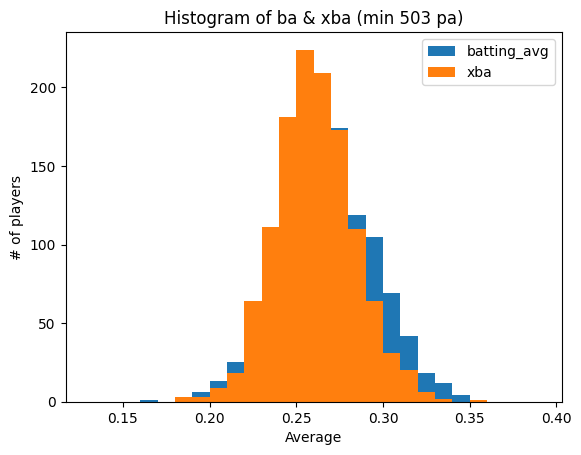

In [607]:
# plotting histograms 
plt.hist(df_min['batting_avg'], label='batting_avg', bins=[x / 100.0 for x in range(13, 40, 1)]) 
plt.hist(df_min['xba'], label='xba',  bins=[x / 100.0 for x in range(13, 40, 1)]) 
  
plt.legend(loc='upper right') 
plt.title('Histogram of ba & xba (min 503 pa)') 
plt.ylabel('# of players')
plt.xlabel('Average')
plt.show()

We can verify the two stats are very similar. Normal batting average appears to have a slightly wider distribution especially on the upper end. This makes sense since xba is intended to eliminate lucky hits from being included.

Next, let's take a look at some power stats. RBIs and HRs are both discrete measurements that are totaled up throughout the season. Average swing speed is a newer stat that shows how fast a player swings their bat on average.

Let's create two scatterplots and identify which measurement, home runs or rbi's, more closely relates to a player's swing speed.

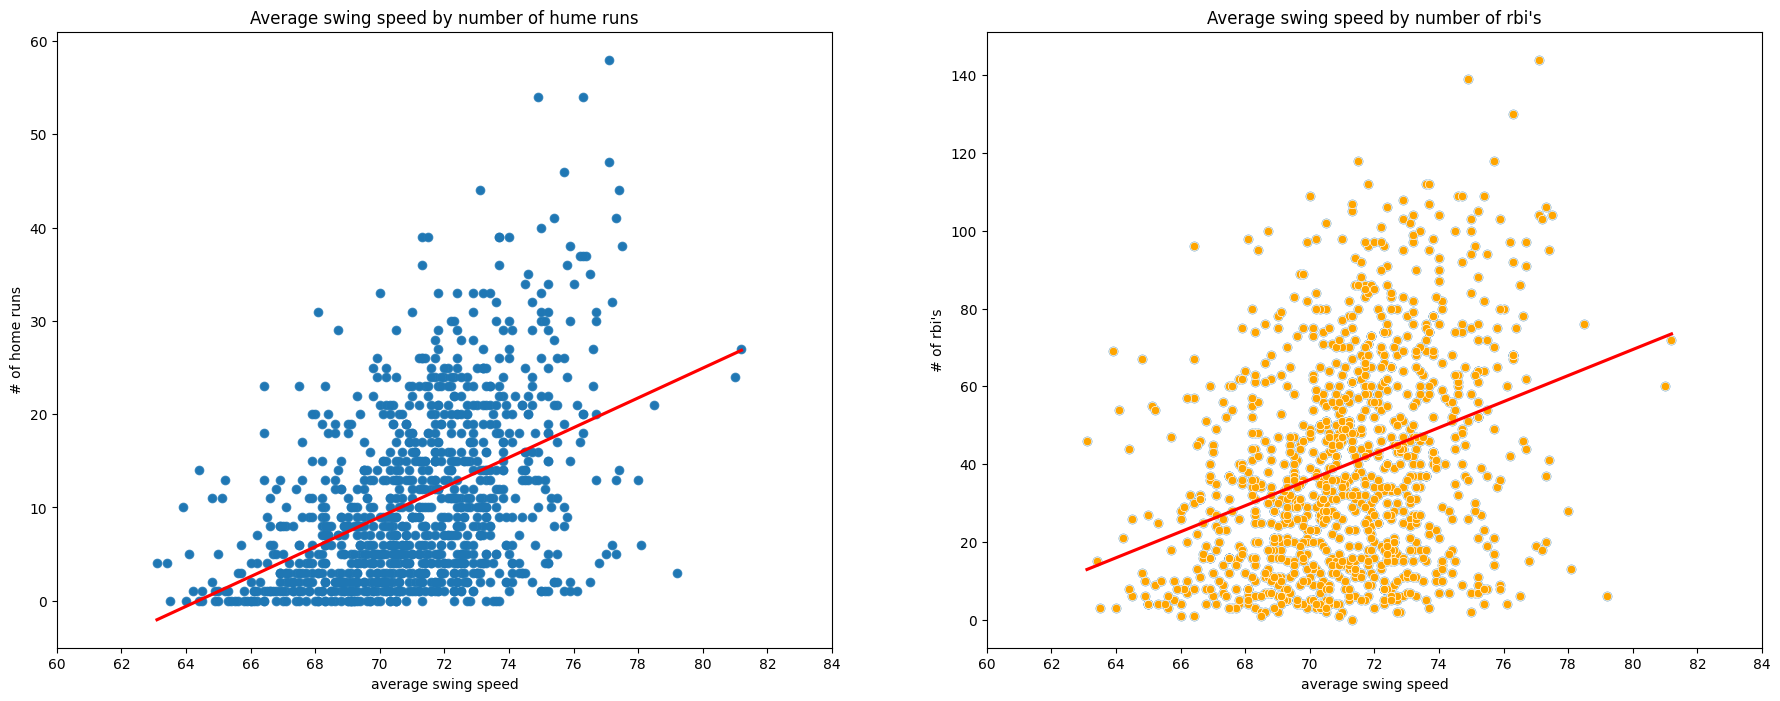

In [608]:
# Create figure
fig, ax = plt.subplots(1, 2, figsize=(22,8))

# Create hr scatterplot
sns.scatterplot(data=df_tracking, x='avg_swing_speed', y='home_run', ax=ax[0])
sns.regplot(data=df_tracking, x='avg_swing_speed', y='home_run', ci=None, line_kws={"color": "red"}, ax=ax[0])
ax[0].set_xticks(range(60, 85, 2))
ax[0].set_title('Average swing speed by number of hume runs')
ax[0].set_xlabel('average swing speed')
ax[0].set_ylabel('# of home runs')

# Create rbi scatterplot
sns.regplot(data=df_tracking, x='avg_swing_speed', y='b_rbi', ci=None, line_kws={"color": "red"}, ax=ax[1])
sns.scatterplot(data=df_tracking, x='avg_swing_speed', y='b_rbi', color='orange', ax=ax[1])
ax[1].set_xticks(range(60, 85, 2))
ax[1].set_title("Average swing speed by number of rbi's")
ax[1].set_xlabel('average swing speed')
ax[1].set_ylabel("# of rbi's")

plt.show()

Both of these graphs show somewhat strong correlation. The spread of RBI's is much wider, but the best fit lines for both are nearly identical. This makes sense since if a player consistently swings the bat harder, they will hit the ball farther hitting more home runs and therefore gaining more RBI's.

Lastly, we can check out a correlation heat map to analyze all of our variablesa nd show which have strong correlation with each other. To do this we will use the pandas dunction corr(), which calculates the standard (Pearson) correlation coefficient. This number is a value between -1 and 1, with exactly 1 or -1 indicating a linear relationship perfectly describes X & Y. A positive value indicates positive correlation, a negative value indicates negative correlation.

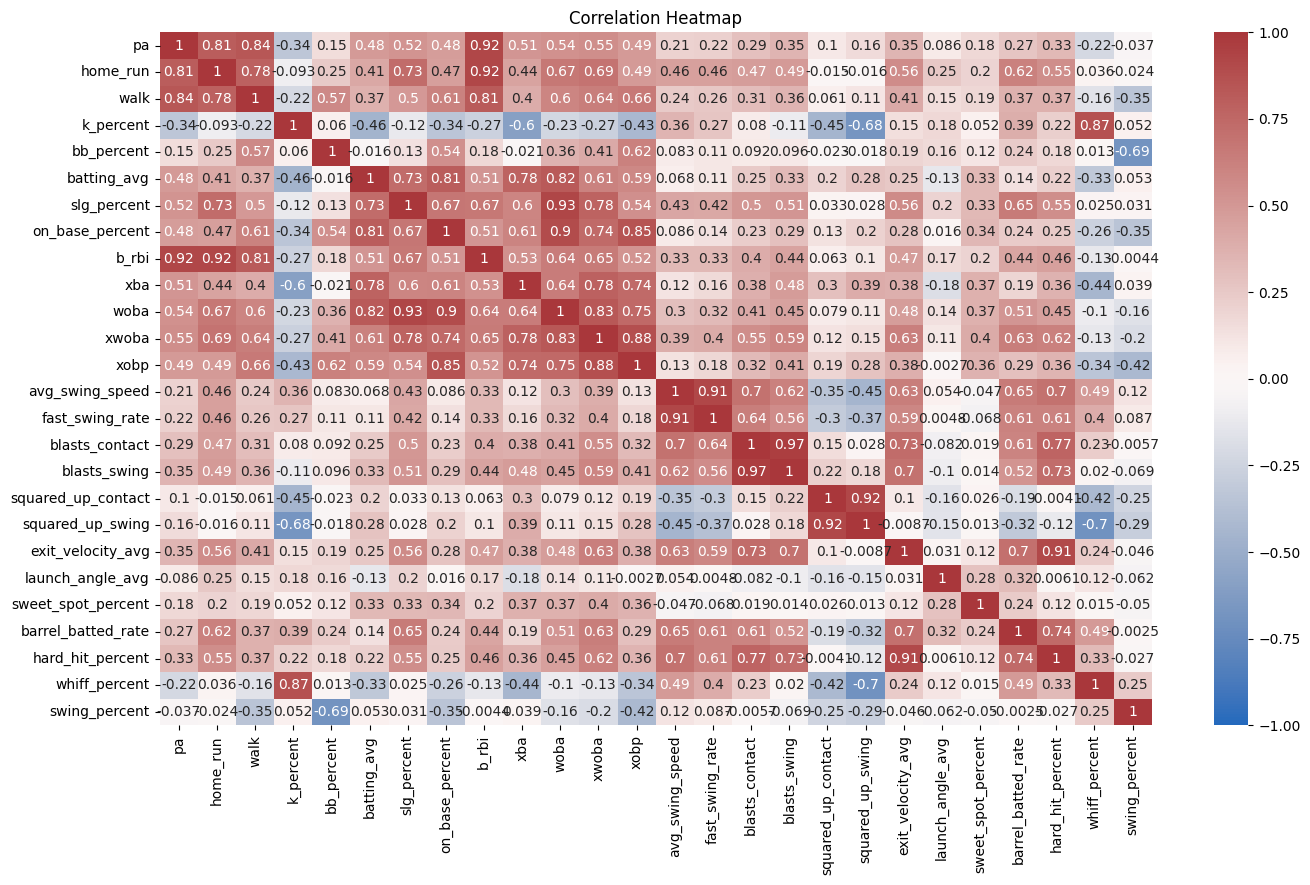

In [609]:
plt.figure(figsize=(16,9))
sns.heatmap(df_tracking.iloc[:, 3:].corr(),vmin=-1, vmax=1, annot=True, cmap=sns.color_palette('vlag', as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

The main diagonal is always 1.0 since it is the same stat being compared to itself. Outside of this main diagonal, all squares with darker red coloring have higher correlcation with each other. From taking a quick look we can see that average swing speed has a 0.46 correlation with home runs, versus a 0.33 correlation with RBI's. Our visualizations earlier showed correlation amongst both comparisons, but the numbers themselves allow us to learn home runs correlate much higher.

One of the squares that sticks out if whiff_percent vs k_percent. Whiffing is when a player swings the bat and does not make contact with the ball. K percent, or strikeout percent, is the percentage of at-bats for a player that end in a strikeout. These two statistics being strtongly correlated indicates that players who swing-and-miss a lot, also strikeout a lot.

Our main statistic of interest, slugging percentage, has a few statistics it is highly correlated with. OBP, WOBA, and XWOBA in particular are all 0.77 or above.

# Analysis and Model Building

Before we begin building out models, we must first pick which type of problem we have. Slugging percentage is a continuous measurement, meaning the value has infinitely many outcomes, similar to someone's height. This means we have a regression problem. Regression problems have a lot of different models to choose from, we will train a few different ones and comnpare the results.

Before we move to training and fitting the model, let's make sure we meet the requirements for linear regression. Let's begin by checking the distrubution across all of our variables.

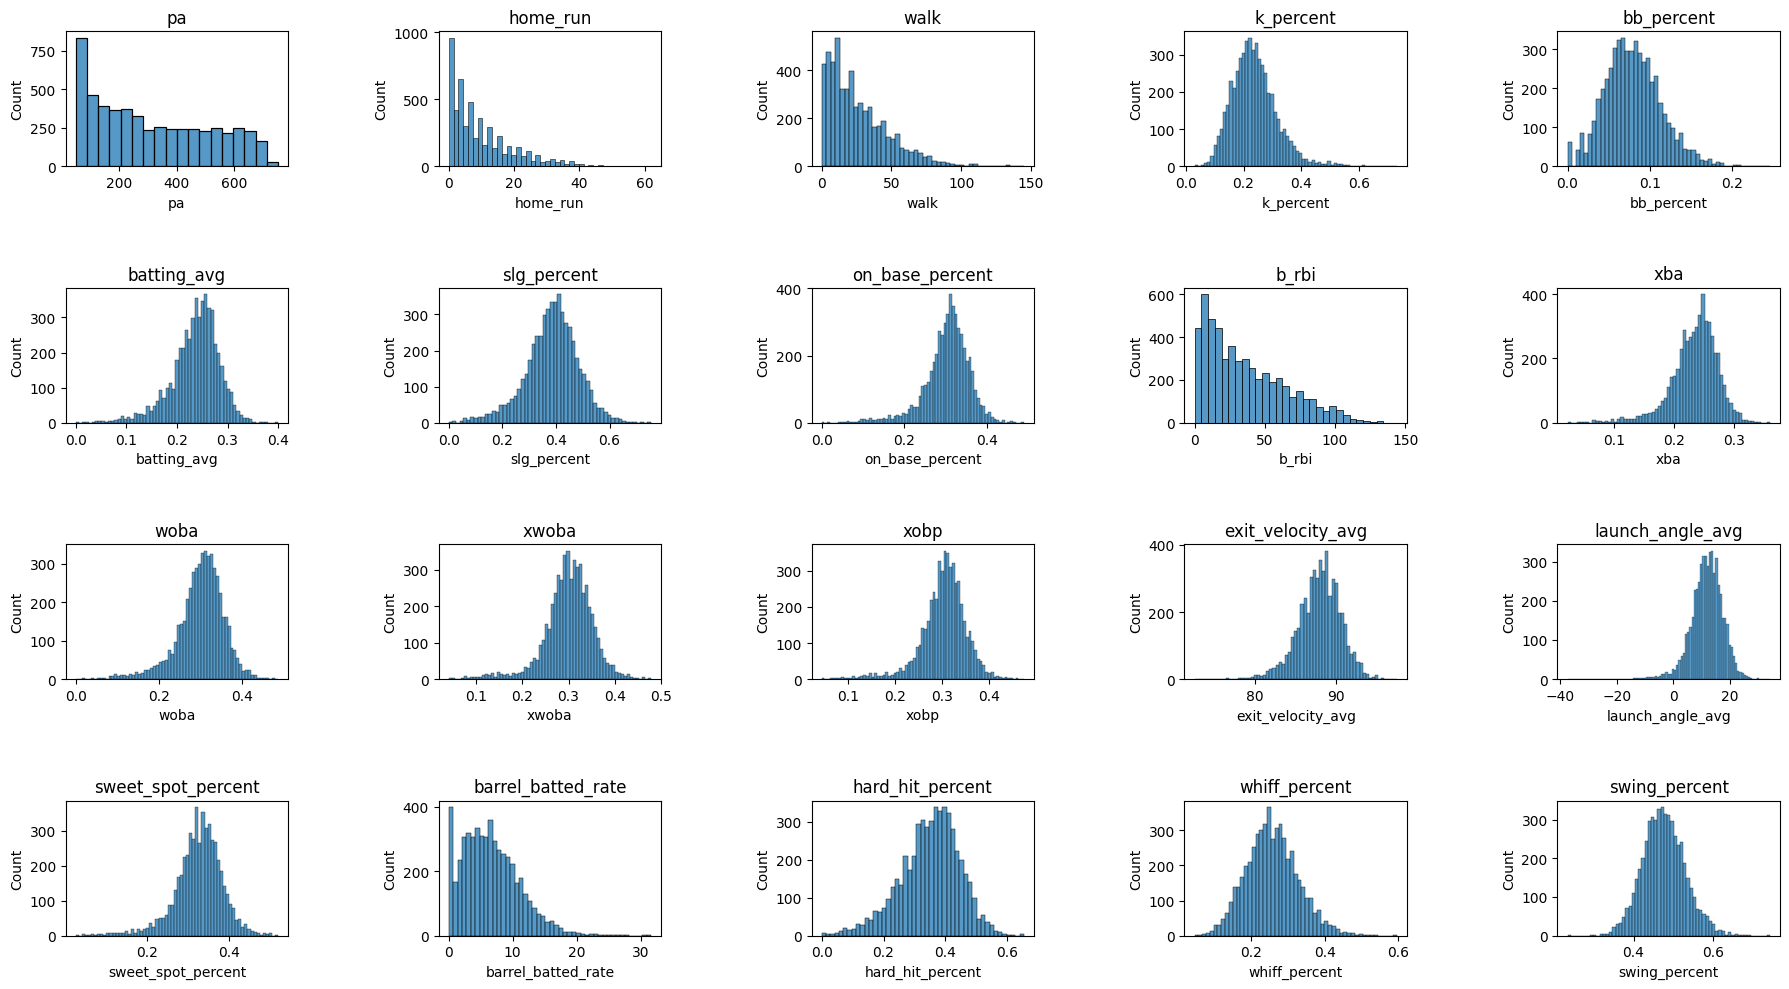

In [610]:
# Create figure
fig, axes = plt.subplots(4,5, figsize=(18, 10))
ax = axes.flatten()

# Plot each field
for i, col in enumerate(df.iloc[:, 3:].columns):
    sns.histplot(df[col], ax=ax[i])
    ax[i].set_title(col)

# Fix padding to prevent overlap
fig.tight_layout(w_pad=6, h_pad=4)
plt.show()

Overall, much of our data has the traits of the classic bell curve which signals them being normally distrubuted. The only variables that do not reflect the bell curve are discrete variables, therefore this strategy of analysis does not apply to them.

In [611]:
# Isolate predictor variables
X = df.iloc[:,3:]
X.drop(columns=['slg_percent'], inplace=True)

Next, we have to ensure there is no multucollinearity. This means, no two independent variables can be highly correlated with eachother. To idenfity any columns like this, we could create another heatmap with the leftover values and drop anything that stands out. Another method is to calculate the Variance Inflation Factor (VIF). VIF starts at 1, and has no upper limit. It can be interpreted as follows:

* A value of 1 indicates there is no correlation between a given explanatory variable and any other explanatory variables in the model.
* A value between 1 and 5 indicates moderate correlation between a given explanatory variable and other explanatory variables in the model, but this is often not severe enough to require attention.
* A value greater than 5 indicates potentially severe correlation between a given explanatory variable and other explanatory variables in the model.

I will also drop any power-related statistics since the target variable, slugging percentage, is a power metric.

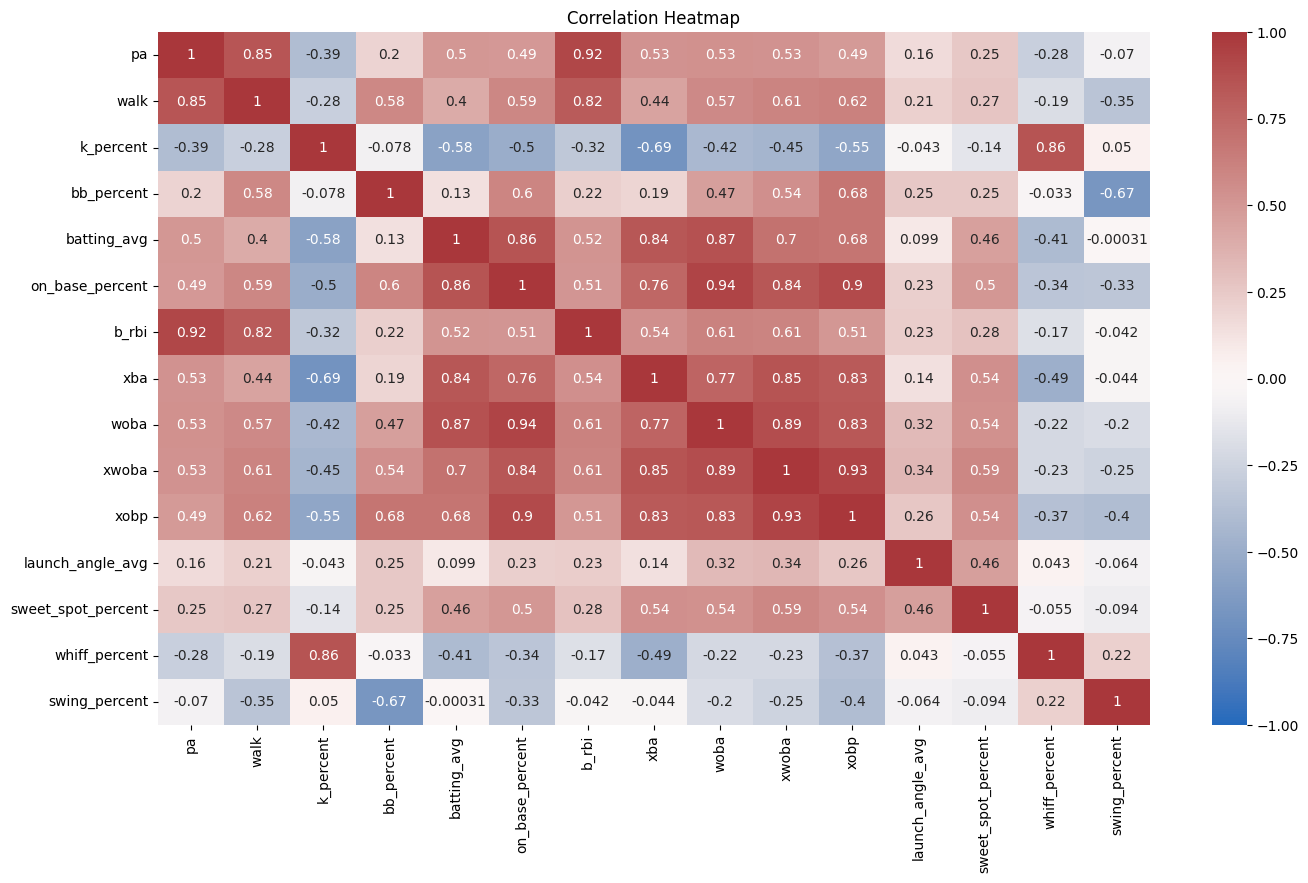

In [612]:
# Drop power-related statistics
X.drop(columns=['home_run', 'exit_velocity_avg', 'barrel_batted_rate', 'hard_hit_percent'], inplace=True)

plt.figure(figsize=(16,9))
sns.heatmap(X.corr(),vmin=-1, vmax=1, annot=True, cmap=sns.color_palette('vlag', as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

The heatmap does result in many clusters of intensely red squares,  k_percent and whiff_percent are very highly correlated because a player that swings-and-misses frequently, will also strikeout frequently. To get a better idea of this, let's look at the VIF.

In [613]:
# For VIF
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF            variable
0      44.514006                  pa
1      25.775073                walk
2      50.677621           k_percent
3     100.205042          bb_percent
4   10158.799344         batting_avg
5   21226.810204     on_base_percent
6      28.071552               b_rbi
7   10026.723959                 xba
8     997.878278                woba
9    1361.767426               xwoba
10  20992.484971                xobp
11      9.610195    launch_angle_avg
12     71.054613  sweet_spot_percent
13     79.686148       whiff_percent
14     99.034309       swing_percent


As we can see from the high VIF scores, we do have high multicolinearity. This makes sense since there are so many variables that are related to each other. We will drop many of the repetitive statistics, prioritizing the more complex ones to make sure our ending predictor variabels are simple.

In [614]:
# Dropping high VIF columns
X.drop(columns=['xba', 'xwoba', 'xobp','woba', 'on_base_percent', 'whiff_percent', 'batting_avg', 'pa', 'sweet_spot_percent', 'walk', 'swing_percent'], inplace=True)

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

        VIF          variable
0  4.662700         k_percent
1  6.047034        bb_percent
2  2.809439             b_rbi
3  5.489926  launch_angle_avg


Now, let's train a linear regression model. We will begin with the data without the minimum plate appearances cutoff value applied, and train both the standard stats, and the dataframe with bat tracking metrics to see which one is better.

In [615]:
# Isolate target variable
y = df['slg_percent']

# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Create linear regression model and fit it to the training dataset
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Use the model to get prediction on the test set
y_pred = lin_reg.predict(X_test)

Let's print out some values of our predictions next the values of our test data to get an idea of our performance.

In [616]:
comp = pd.DataFrame(y_test)
comp['predictions'] = y_pred.tolist()
comp.rename(columns={'slg_percent' : 'test'}, inplace=True)
comp.head(10)

,test,predictions
1158,0.488,0.461657
1860,0.376,0.344555
3089,0.255,0.255436
803,0.293,0.327172
168,0.422,0.396712
5330,0.500,0.497081
5290,0.376,0.358423
3773,0.317,0.334548
2892,0.433,0.443883
1047,0.262,0.332305


We can evaluate our model's performance by calculating the mean squared error and mean absolute error across the entire dataset. To understand better what exactly we are comparing, the metrics are defined as:

* **Mean Squares Error (MSE)**: The difference between the original and predicted values extracted by squared the average difference over the data set.
* **Mean Absolute Error (MAE)**: The difference between the original and predicted values extracted by averaged the absolute difference over the data set.
* **R-Squared (Coefficient of Determination)**: The coefficient of how well the values fit compared to the original values. The value from 0 to 1 interpreted as percentages. The higher the value is, the better the model is.

In [617]:
# Evaluate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print values
print('Evlaution of Linear Regression model for standard stats and at least 50 pa:')
print(f'Mean Squared Error: {mse:.8f}') 
print(f'Mean Absolute Error: {mae:.8f}')
print(f'R-Squared: {r2:.5f}')

# Store into table for later use
results = pd.DataFrame(columns=['Data', 'MSE', 'MAE', 'R2'])
results.loc[len(results)] = ["Std_Stats", mse, mae, r2]

Evlaution of Linear Regression model for standard stats and at least 50 pa:
Mean Squared Error: 0.00499531
Mean Absolute Error: 0.05433586
R-Squared: 0.48681


Our has a great MSE and MAE score. Let's create an Ordinary Least Squares summary so that we can analyze each independent variable on it's own.

In [618]:
lin_reg = smf.ols(formula='slg_percent ~ k_percent + bb_percent + b_rbi + launch_angle_avg', data=df).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            slg_percent   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     1283.
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        16:24:08   Log-Likelihood:                 6584.0
No. Observations:                5336   AIC:                        -1.316e+04
Df Residuals:                    5331   BIC:                        -1.313e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2906      0.005     64.471      0.000       0.282       0.299
k_percent           -0.1574      0.013    -12.272      0.000      -0.183      -0.132
bb_percent           0.2901      0.030      9.827      0.000       0.232       0.348
b_rbi                0.0019   3.74e-05     50.284      0.000       0.002       0.002
launch_angle_avg     0.0034      0.000     19.255      0.000       0.003       0.004
==============================================================================
Omnibus:                      430.446   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              845.844
Skew:                           0.549   Prob(JB):                    2.12e-184
Kurtosis:                       4.613   Cond. No.                     1.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-value for all of our predictor variables is very low, indicating high association amongst them. We also have very high positive association between walk rate (bb_percent) and our target variable slugging percentage. In the MLB, a walk does not count as an at-bat for a player, only a plate appearance. When we looked at the formula for slugging percentage earlier, we saw it is calculated by dividing by the number of at-bats a player has had. A player that is able to get many walks will be able to lower this number, increasing their slugging percentage overall.

Now, let's do the same model building and analysis but for our dataset with the minimum plat appearance cutoff value of 503 applied and compare it's performance to this one.

In [619]:
# Get predictor and target variables, perform train test split, create and fit to model, make predictions on test data, calculate metrics
X = df_min[['k_percent', 'bb_percent', 'b_rbi', 'launch_angle_avg']]
y = df_min['slg_percent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

lin_reg_min = LinearRegression()
lin_reg_min.fit(X_train, y_train)

y_pred = lin_reg_min.predict(X_test)

# Evaluate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print values
print('Evlaution of Linear Regression model for standard stats and at least 50 pa:')
print(f'Mean Squared Error: {mse:.8f}') 
print(f'Mean Absolute Error: {mae:.8f}')
print(f'R-Squared: {r2:.5f}')

# Store into table for later use
results.loc[len(results)] = ["Std_Stats_min", mse, mae, r2]

Evlaution of Linear Regression model for standard stats and at least 50 pa:
Mean Squared Error: 0.00148627
Mean Absolute Error: 0.03122085
R-Squared: 0.60544


In [620]:
print(results)

            Data       MSE       MAE        R2
0      Std_Stats  0.004995  0.054336  0.486815
1  Std_Stats_min  0.001486  0.031221  0.605440
